In [1]:
import pandas as pd

df_raw = pd.read_csv('sphist.csv')

In [2]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


# Task: predict stock prices
Perform training on data from 1950-2012 and perform predictions on 2013-2015.

In [3]:
def convert_and_sort(df):
    new_cols = df.columns.str.lower().str.replace(' ', '_')
    df.columns = new_cols
    df['date'] = pd.to_datetime(df['date'])
    df_output = df.sort_values(by='date')
    return df_output.reset_index(drop=True)

df = convert_and_sort(df_raw)

In [4]:
df['close'].iloc[0:5].mean()

16.9

In [5]:
df['close']

0          16.660000
1          16.850000
2          16.930000
3          16.980000
4          17.080000
            ...     
16585    2102.629883
16586    2079.510010
16587    2049.620117
16588    2091.689941
16589    2077.070068
Name: close, Length: 16590, dtype: float64

In [6]:
def calculate_rolling_avg(win=[5,30,365]):
    # must avoid to take current day, hence we shift values by 1 onwards
    for w in win:
        df[f'rolling_avg_{w}_close'] = df['close'].rolling(window=w).mean().shift(1)
    return df

df = calculate_rolling_avg()

In [7]:
df['rolling_avg_5_close'].head(10)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5    16.900
6    16.974
7    17.022
8    16.988
9    16.926
Name: rolling_avg_5_close, dtype: float64

In [8]:
def check_validity_win_5(df, start):
    end = start + 5
    #check first n rows
    output = df['close'].iloc[start:end].to_frame()
    output['mean'] = output['close'].mean()   
    return output

check_validity_win_5(df, start=3)

,close,mean
3,16.980000,16.988
4,17.080000,16.988
5,17.030001,16.988
6,17.090000,16.988
7,16.760000,16.988


In [9]:
def generate_train_test(data, split_date = '2013-01-01'):
    df_nonulls = data.dropna(axis=0)
    train = df_nonulls[df_nonulls['date'] < split_date]
    test = df_nonulls[df_nonulls['date'] >= split_date]
    return train, test

train, test = generate_train_test(df)

# Test LR model
We take MAE as an error metric and initialize a LinearRegression over it.

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
def fit_and_predict(train, test, features, target='close'):
    lr = LinearRegression()
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # train the model
    lr.fit(X_train, y_train)

    # predict
    test['yhat'] = lr.predict(X_test)
    
    # print error
    mse = mean_squared_error(test[target], test['yhat'])
    rmse = np.sqrt(mse)
    r2 = lr.score(X_train, y_train)
    print('MSE: {}, \nRMSE: {}, \nR-squared: {}'.format(mse, rmse, r2))
    return test

In [12]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'adj_close',
       'rolling_avg_5_close', 'rolling_avg_30_close', 'rolling_avg_365_close'],
      dtype='object')

In [13]:
features =  [col for col in df.columns if col.startswith('rolling')]

preds = fit_and_predict(train, test, features)

MSE: 493.7313030125896, 
RMSE: 22.220065324219675, 
R-squared: 0.9995215140197241


<AxesSubplot:xlabel='date'>

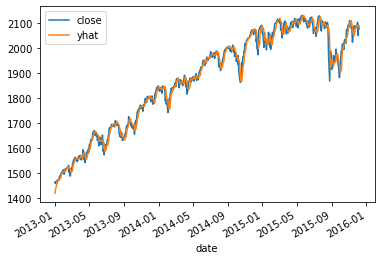

In [14]:
import matplotlib.pyplot as plt
test.set_index('date')[['close','yhat']].plot()